In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

from models import *
from utils import load_dataset, training_steps, evaluation_step
import yaml
import torch
from torch.utils.data import DataLoader
import math
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 64
with open('./parameters/VAE_MNIST.yaml', 'rb') as f:
    config = yaml.safe_load(f)

data, unnormalize, nb_classes = load_dataset(config)
dataloader = DataLoader(data, batch_size = BS, shuffle = True)

test_data, _, _ = load_dataset(config, training = False)
test_dataloader = DataLoader(test_data, batch_size = BS, shuffle = True)


# VAE 3D

In [8]:
vae = VAE_3D(config, dataloader.dataset[0][0].shape, nb_classes)

vae.to(device)

VAE_3D(
  (enc_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (mlp_mu): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=2, bias=True)
      (1):

VAE epoch: 19.000 Loss: 4443.478: 100%|██████████| 938/938 [00:32<00:00, 28.88it/s] 


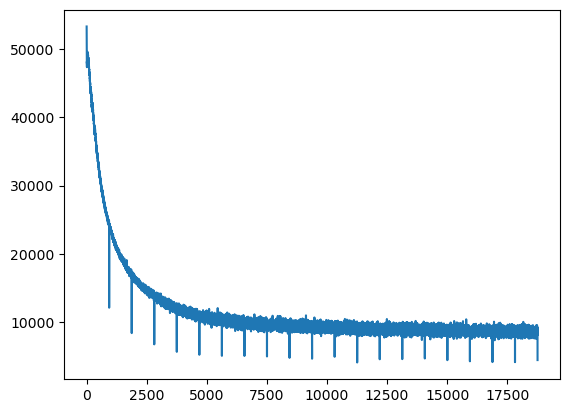

In [9]:
losses = training_steps(vae, dataloader,unnormalize)
plot(losses)

In [10]:
batch = next(iter(test_dataloader))[0].to(device)
vae.eval()
with torch.no_grad():
    out = vae(batch)
    loss_dict = vae.loss_function(out, batch, unnormalize)
loss_dict

{'loss': tensor(8433.8955, device='cuda:0'),
 'recon_loss': tensor(8432.4414, device='cuda:0'),
 'kl_loss': tensor(14.5458, device='cuda:0')}

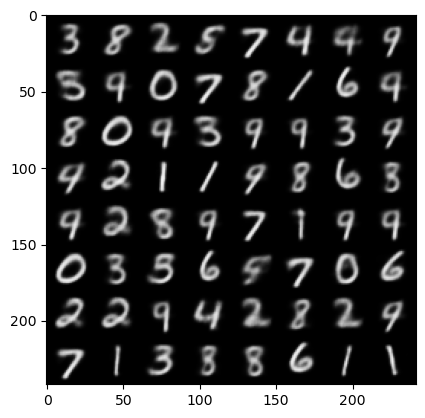

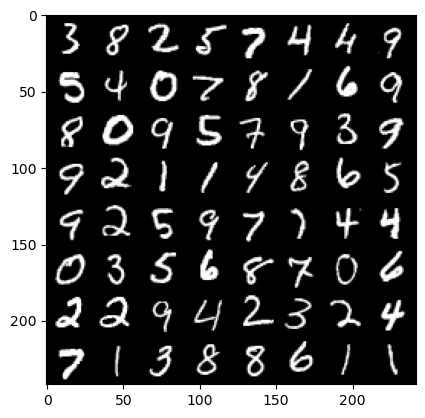

In [17]:
imshow(torchvision.utils.make_grid(unnormalize(out[0]).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

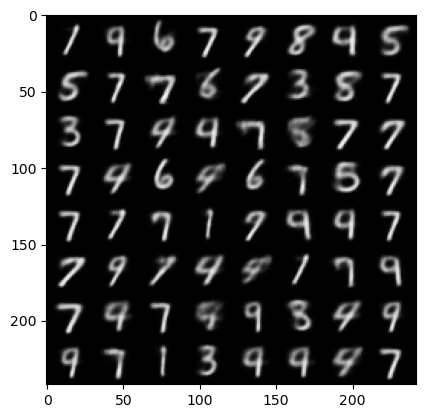

In [18]:
img_sampled = vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img_sampled).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

# VAE complex

In [16]:
with open('./parameters/VAEcomplex_MNIST_params.yaml', 'rb') as f:
    config_complex = yaml.safe_load(f)
vae_complex = VAE_complex(config_complex, dataloader.dataset[0][0].shape, nb_classes)
vae_complex.to(device)
losses_complex = training_steps(vae_complex,dataloader, unnormalize)

VAE epoch: 14.000 Loss: 9129.564:  50%|█████     | 472/938 [00:16<00:16, 28.65it/s] 

In [ ]:
plot(losses_complex)

In [ ]:
batch = next(iter(test_dataloader))[0].to(device)
vae_complex.eval()
with 

# Multi-Stage VAE

In [8]:
with open('./parameters/multistage_vae_params.yaml', 'rb') as f:
    config_multi = yaml.safe_load(f)
multi_vae = MultiStage_VAE(config_multi, dataloader.dataset[0][0].shape, nb_classes)
multi_vae.to(device)
losses_multi = training_steps(multi_vae,dataloader, unnormalize)

VAE epoch: 19.000 Loss: 3094.400: 100%|██████████| 938/938 [00:29<00:00, 31.81it/s]


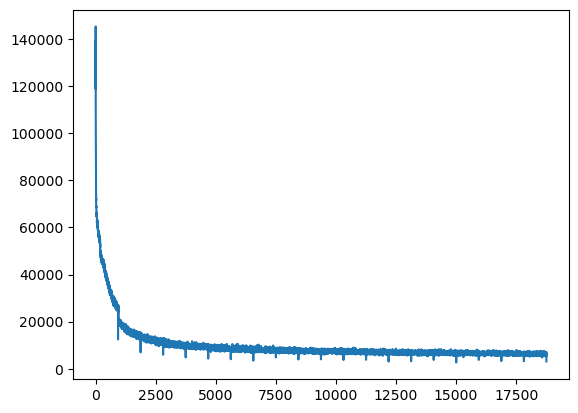

In [9]:
plot(losses_multi)

In [10]:
batch = next(iter(test_dataloader))[0].to(device)
multi_vae.eval()
with torch.no_grad():
    out = multi_vae(batch)
    loss_dict = multi_vae.loss_function(out, batch, unnormalize)
loss_dict

{'loss': tensor(6322.4155, device='cuda:0'),
 'recon_loss': tensor(2918.7505, device='cuda:0'),
 'kl_loss': tensor(161.4305, device='cuda:0'),
 'l1__loss': tensor(3387.5220, device='cuda:0')}

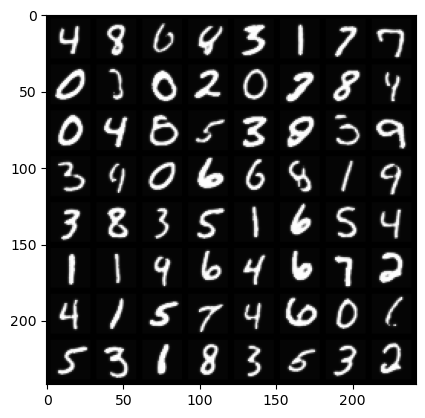

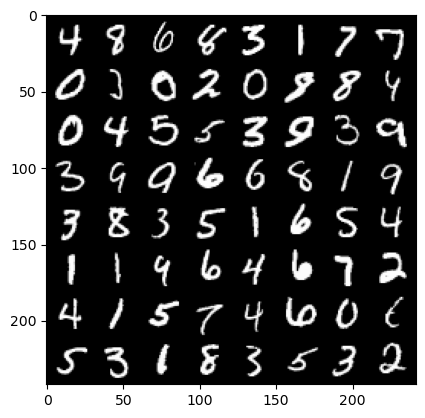

In [11]:
imshow(torchvision.utils.make_grid(unnormalize(out[0]).cpu(), int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch).cpu(), int(math.sqrt(BS))).permute(1,2,0))


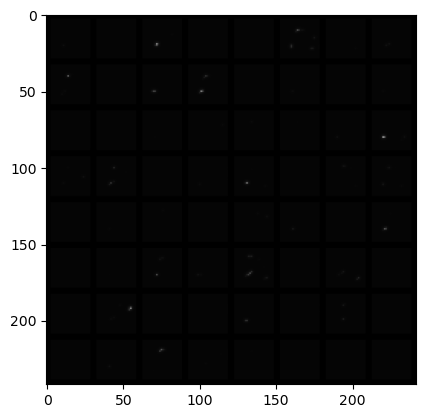

In [14]:
multi_img_samp = multi_vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(multi_img_samp).cpu(), int(math.sqrt(BS))).permute(1,2,0))


# VQ-VAE